In [1]:
import os
import re
import numpy as np
import cv2
from matplotlib import pyplot as plt
image_path_A='data/image/'
image_path_B='data/image/6'
mask_path = 'data/mask'

# Load CYCLEGAN Model

In [2]:
# example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
# from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
 # example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]
 
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    return X
 
# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        plt.subplot(1, len(images), 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(images[i])
        # title
        plt.title(titles[i])
    plt.show()

# Run and Save

In [3]:
from PIL import Image
import numpy as np
def save_image(data,filename):
    #[-1,1] to [0,1]
    data = ((np.squeeze(data)+1)/2)#[0,1]
#     print(data.shape)
    #Rescale to 0-255 and convert to uint8
    rescaled = (255.0*data).astype(np.uint8)
    # print(data.shape)
    im = Image.fromarray(rescaled)
    im.save(filename)

In [6]:
 
# # load dataset
A_data, B_data = load_real_samples('birds_256.npz')
# print('Loaded', A_data.shape, B_data.shape)
# # load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_001050.h5', cust)
model_BtoA = load_model('g_model_BtoA_001050.h5', cust)
# plot A->B->A

n1 = A_data.shape[0]
n2 = B_data.shape[0]
for i in range(n1):
#     print('{}/{}'.format(n1,i))
    A_real = A_data[i]
    A_real = np.expand_dims(A_real, axis=0)
#     print(A_real.shape)
    B_generated  = model_AtoB.predict(A_real)
    save_image(A_real,'A_real/A_{}.jpg'.format(i))
    save_image(B_generated,'A_to_B/A_{}.jpg'.format(i))
    
# for i in range(n2):
#     print('{}/{}'.format(n2,i))
    B_real = B_data[i]
    B_real = np.expand_dims(B_real, axis=0)
#     print(A_real.shape)
    A_generated  = model_BtoA.predict(B_real)
    save_image(B_real,'B_real/B_{}.jpg'.format(i))
    save_image(A_generated,'B_to_A/B_{}.jpg'.format(i))
    


# Visualization of Cycle GAN

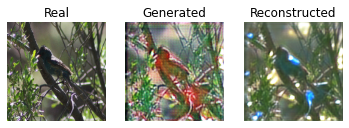

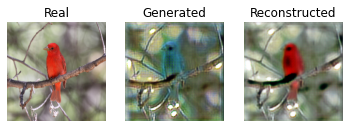

In [7]:
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

# Load U-net

In [20]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('.jpg', '.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + imgNames[i]) 
            mask = plt.imread(maskAddr + maskNames[i])
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
#         print(img.shape)
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj
framObjTrain = LoadData( framObjTrain, imgPath = 'data/images',
                        maskPath='data/masks'
                         , shape = 256)

X_train = np.array(framObjTrain['img'])
Y_train = np.array(framObjTrain['mask'])

In [23]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution
# import tensorflow as tf
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

    
    

In [25]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
model = GiveMeUnet(inputs, droupouts= 0.07)
# unet_1.load_weights('./checkpoints/my_checkpoint')
model.load_weights(latest)
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
loss, acc = model.evaluate(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

4/4 - 5s - loss: 0.1090 - accuracy: 0.9261
Restored model, accuracy: 92.61%


In [26]:
def predict (img, model):
    ## getting and proccessing val data
#     img = valMap['img']
#     mask = valMap['mask']
#     mask = mask[0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc

def Plotter(img, predMask):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
#     plt.subplot(1,4,3)
#     plt.imshow(groundTruth)
#     plt.title('actual Mask')
    
    imh = predMask
    imh[imh < 0.5] = 0
    imh[imh > 0.5] = 1
    imj=cv2.merge((imh, imh, imh)) * img
#     print(np.max(imj))
    plt.subplot(1,3,3)
    plt.imshow(imj.astype(int))
    plt.title('segmented Image')

<ipython-input-26-5a880b209ee4>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9,9))


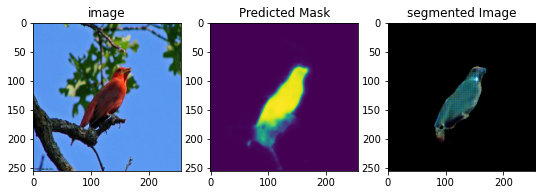

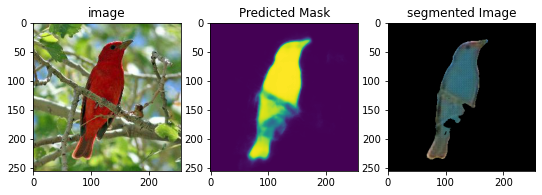

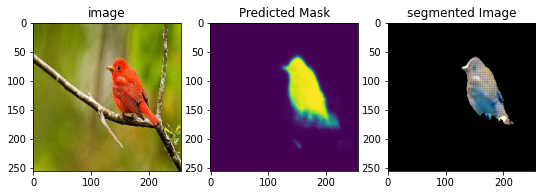

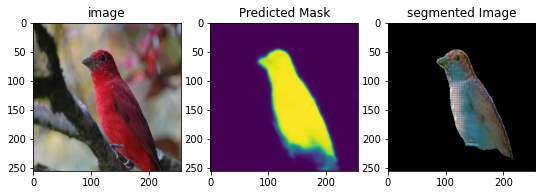

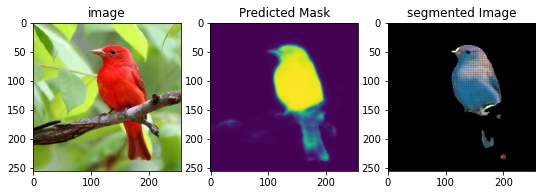

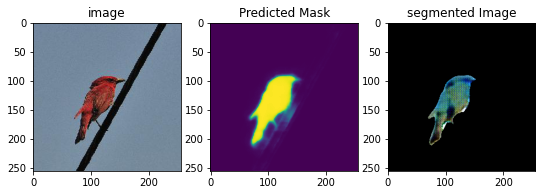

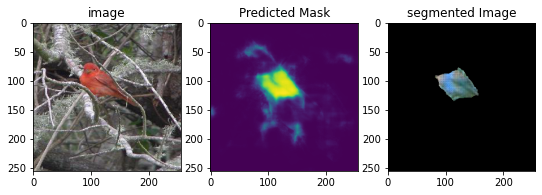

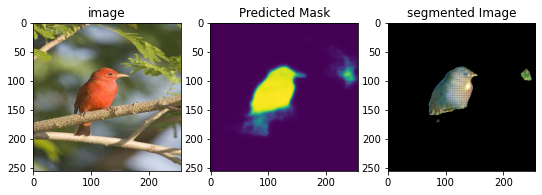

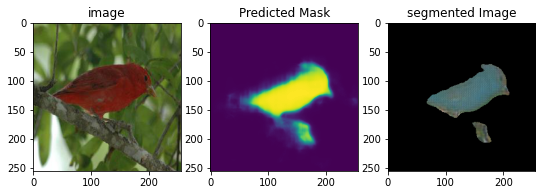

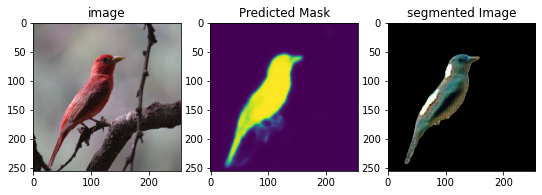

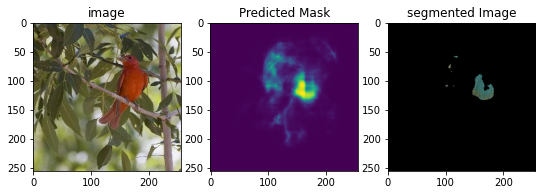

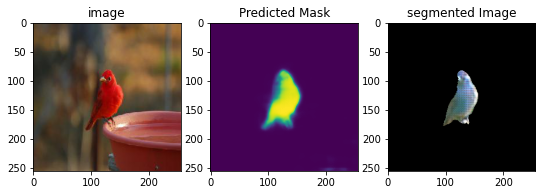

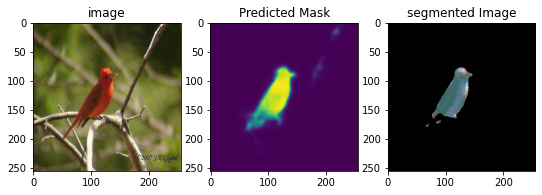

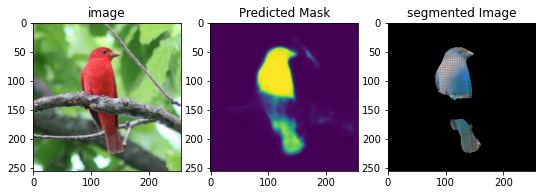

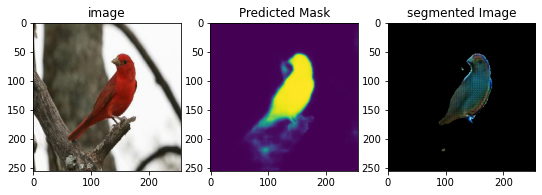

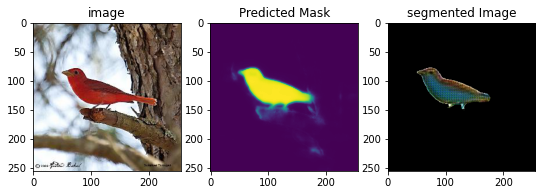

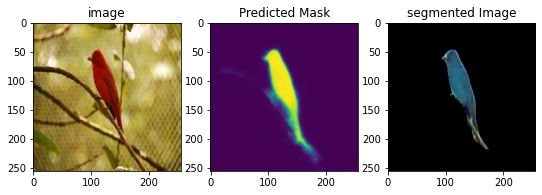

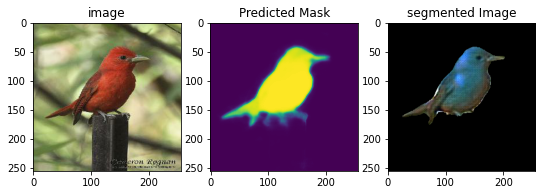

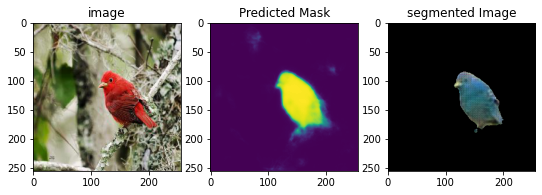

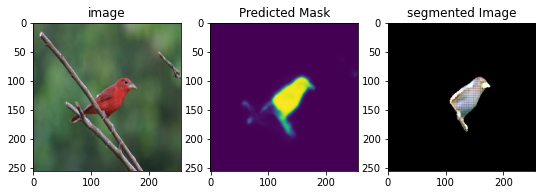

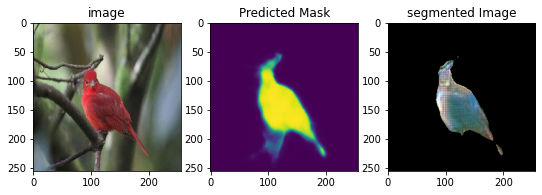

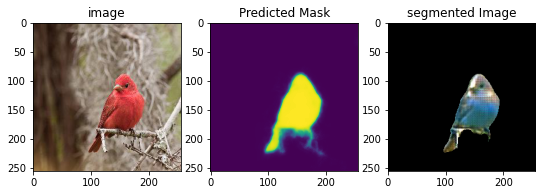

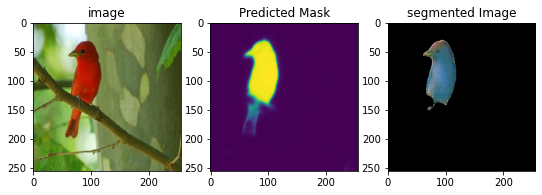

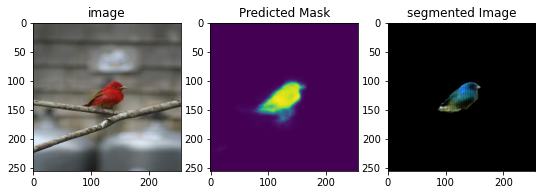

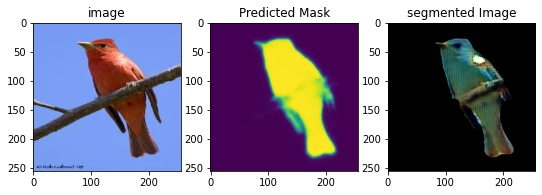

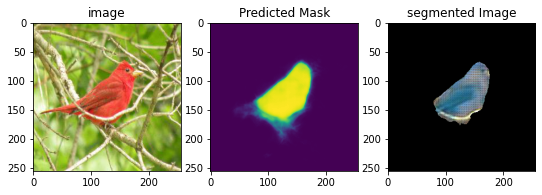

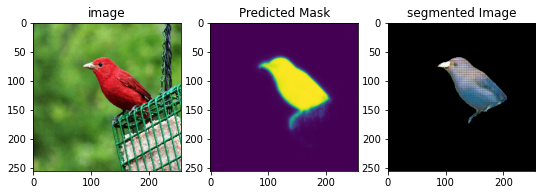

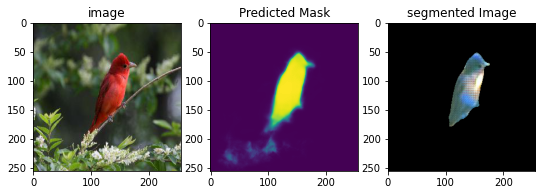

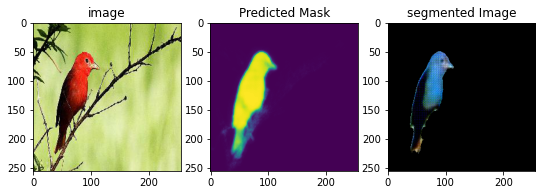

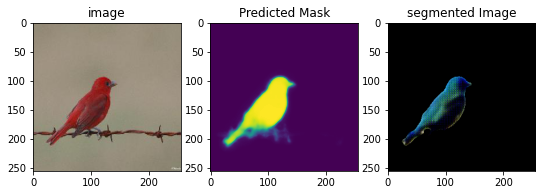

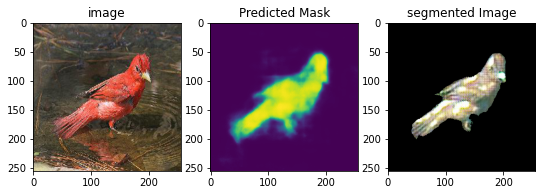

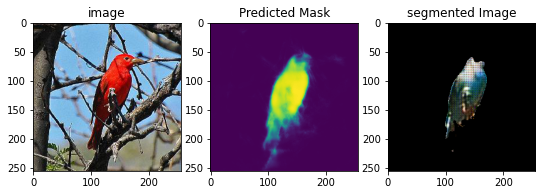

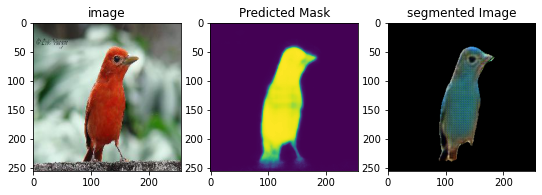

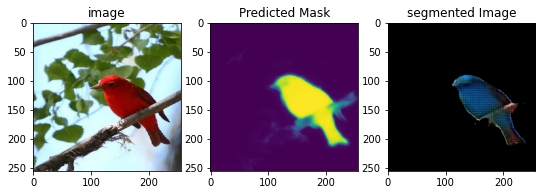

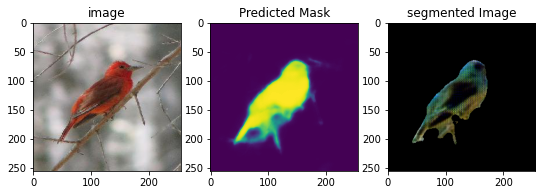

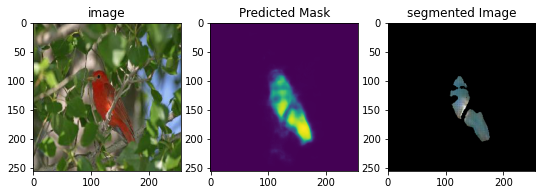

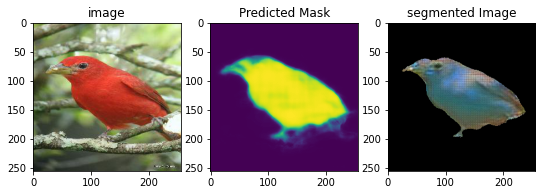

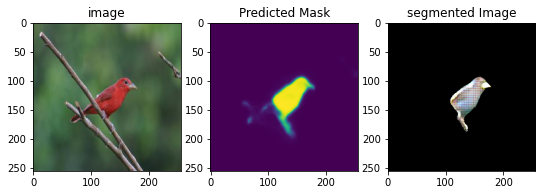

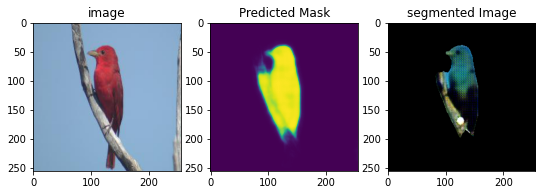

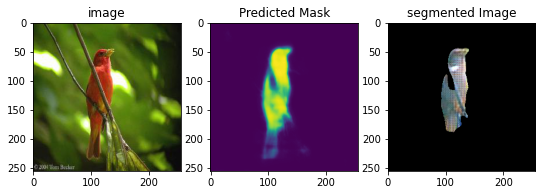

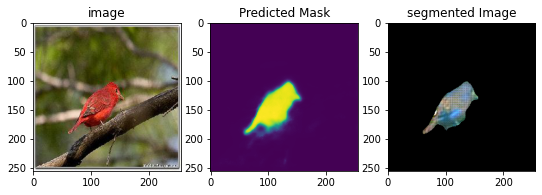

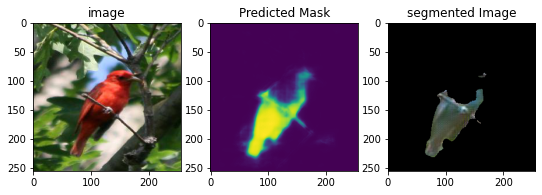

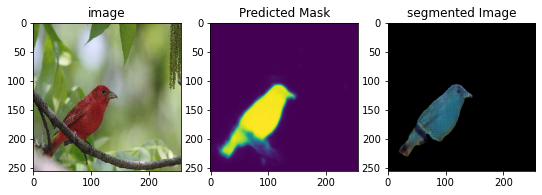

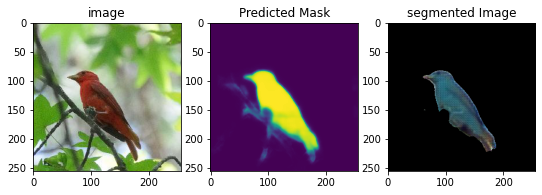

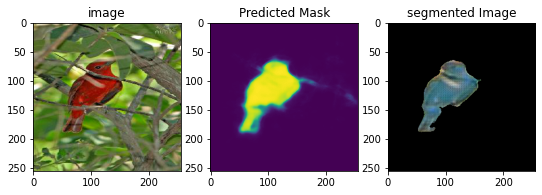

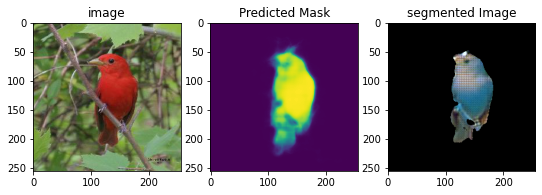

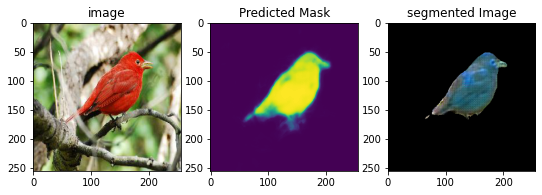

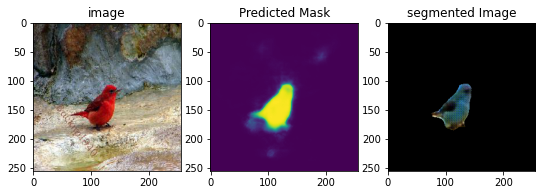

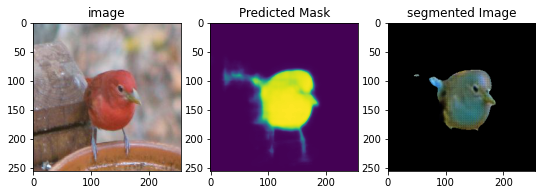

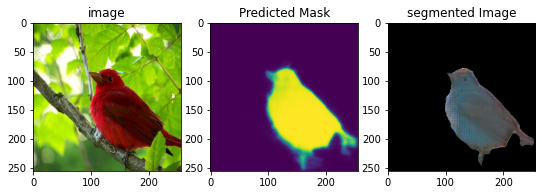

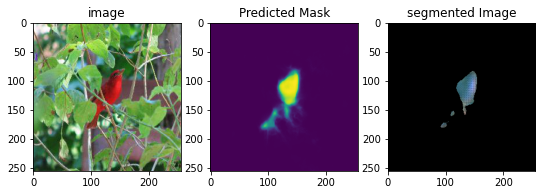

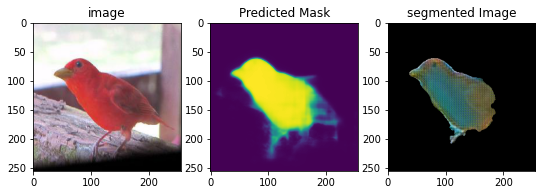

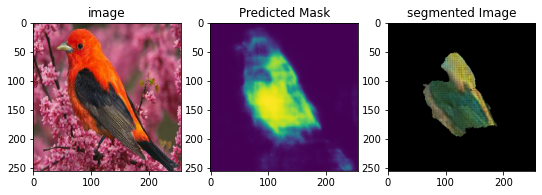

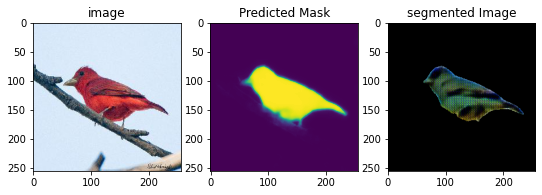

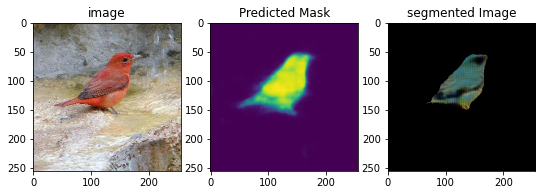

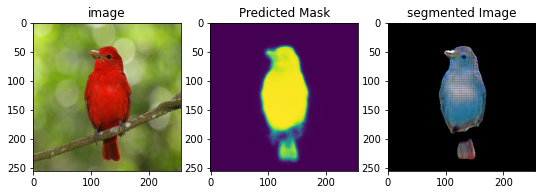

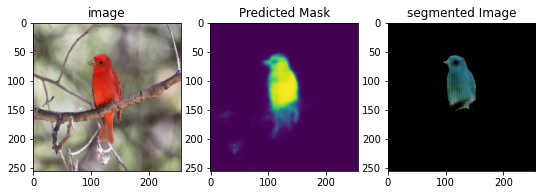

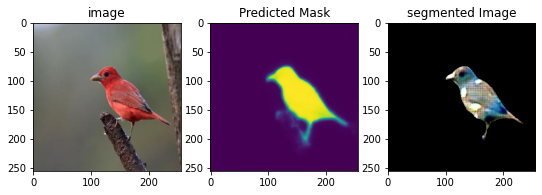

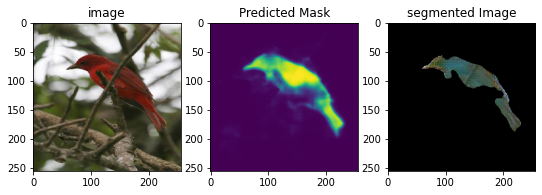

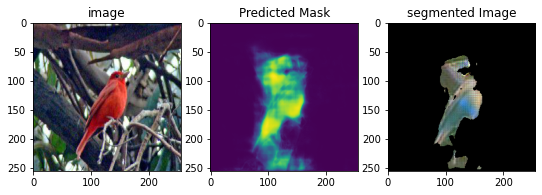

In [30]:
back_path='B_real/'
butterfly_path = 'B_to_A/'
save_path = 'Secle_BtoA/'
for filename in os.listdir(back_path):
#     print(filename)
    if filename.endswith(".jpg"):
        # load and resize the image
    #         print(path + filename)
        img = plt.imread(back_path + filename) 
#         img =cv2.resize(img,(256,256))
#         img = ((np.array(img)/255*2-1)*127.5+127.5)/255
        img = np.expand_dims(img, axis=0)
#         print(img.shape)
#         print(np.max(img))
        mask, img= predict(img,model)
#         mask[mask <= 0.5] = 0
#         mask[mask > 0.5] = 1
        Plotter(np.squeeze(img), mask[0])
        back = np.multiply((1-mask),img)
#         print(back.shape)
        back = np.squeeze(back)/255
#         print(mask.shape)
#         imj=cv2.merge((mask, mask, mask)) * img
#         print(np.max(back))
#         plt.subplot(1,3,3)

#         back = np.squeeze(img*(mask-1)*-1)
        butterfly = plt.imread(butterfly_path+filename)
#         butterfly =cv2.resize(butterfly,(256,256))
        butterfly = ((np.array(butterfly)/255*2-1)*127.5+127.5)/255
#         butterfly = np.expand_dims(butterfly, axis=0)
        plt.imshow(np.squeeze(mask))
        plt.title('segmented Image')
#         break
        butterfly = np.multiply(mask,butterfly)
        butterfly=np.squeeze(butterfly)
        
#         print(np.max(butterfly))
#         print(np.max(back))
        result = back+butterfly
        plt.imshow(butterfly)
        plt.title('segmented Image')
#         break
        rescaled = (255.0*result).astype(np.uint8)
        # print(data.shape)
        im = Image.fromarray(rescaled)
        im.save(save_path+filename)
#         save_image(result,save_path+filename)